<a href="https://colab.research.google.com/github/sushirito/Hg2/blob/main/bathymetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install essential libraries
!pip install plotly geopandas rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 95.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

# For XYZ data (tabular format)
bathy_df = pd.read_csv('/content/Apr19_bathy_NAVD88.xyz',
                      delim_whitespace=True,
                      names=['Longitude', 'Latitude', 'Depth'])

# For ASC/Esri ASCII (gridded format)
with open('Apr19_bathy_NAVD88.asc') as f:
    ncols = int(f.readline().split()[1])
    nrows = int(f.readline().split()[1])
    xll = float(f.readline().split()[1])  # xllcorner/center
    yll = float(f.readline().split()[1])  # yllcorner/center
    cellsize = float(f.readline().split()[1])
    nodata = float(f.readline().split()[1])

    data = np.loadtxt(f, dtype=np.float32)

depth_grid = np.flipud(data)  # ASC files are top-to-bottom

<ipython-input-3-c25d3307aaee>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bathy_df = pd.read_csv('/content/Apr19_bathy_NAVD88.xyz',


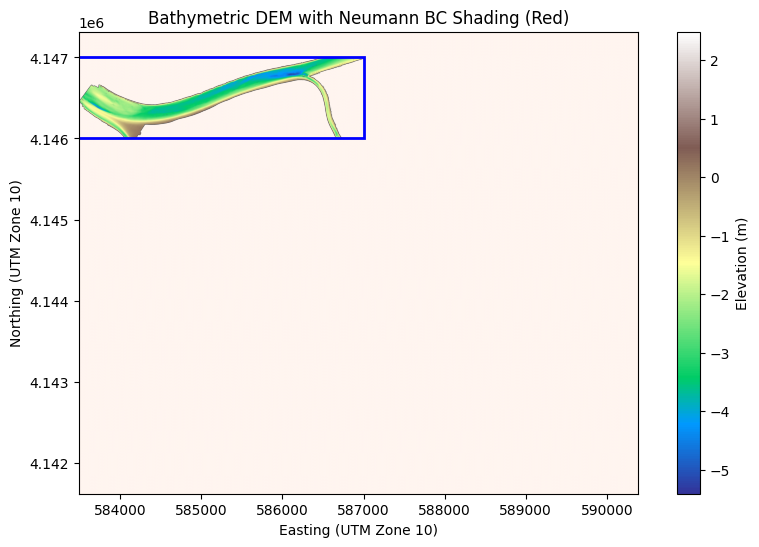

In [39]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    # Get spatial extent
    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])
    X, Y = np.meshgrid(x_coords, y_coords)

    # Define bounding box (river region candidate)
    x_range = (583000, 587000)
    y_range = (4146000, 4147000)

    # Valid river points: inside bounding box AND non-NaN
    valid_mask = ((X >= x_range[0]) & (X <= x_range[1]) &
                  (Y >= y_range[0]) & (Y <= y_range[1]) &
                  (~np.isnan(array)))
    # Neumann BCs applied on all other points
    neumann_mask = ~valid_mask

# Plot DEM with Neumann BC overlay
plt.figure(figsize=(10, 6))
plt.imshow(array, cmap="terrain", interpolation="bilinear", origin="upper",
           extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label="Elevation (m)")

# Create an overlay: value 1 for Neumann points, NaN elsewhere so they appear in red
neumann_overlay = np.where(neumann_mask, 1, np.nan)
plt.imshow(neumann_overlay, cmap="Reds", alpha=1, origin="upper",
           extent=[x_min, x_max, y_min, y_max])

# Draw the bounding box (in blue) for visual reference
rect = Rectangle((x_range[0], y_range[0]),
                 x_range[1] - x_range[0],
                 y_range[1] - y_range[0],
                 linewidth=2, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)

plt.title("Bathymetric DEM with Neumann BC Shading (Red)")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.show()